# CSP Solver am Beispiel Kakuro

```
 *   | s_0 | s_1 |
------------------
 s_2 |  a  |  b  |
------------------
 s_3 |  c  |  d  | 
------------------
```

In [1]:
def print_kakuro_setup(s0, s1, s2, s3):
    print("     | ", s0, " | ", s1, " |")
    print("------------------")
    print(" ", s2, " |  a  |  b  |")
    print("------------------")
    print(" ", s3, " |  c  |  d  |")
    print("------------------\n")


all_instances = [
    (1, 2, 2, 1),
    (1, 2, 1, 2),
    (2, 1, 2, 1),
    (1, 3, 3, 1),
    (1, 3, 1, 3),
    (3, 1, 3, 1),
    (2, 3, 3, 2),
    (2, 3, 2, 3),
    (3, 2, 3, 2),
    (1, 1, 1, 1),
    (2, 2, 2, 2),
    (3, 3, 3, 3),
]
for instance in all_instances:
    print_kakuro_setup(*instance)

     |  1  |  2  |
------------------
  2  |  a  |  b  |
------------------
  1  |  c  |  d  |
------------------

     |  1  |  2  |
------------------
  1  |  a  |  b  |
------------------
  2  |  c  |  d  |
------------------

     |  2  |  1  |
------------------
  2  |  a  |  b  |
------------------
  1  |  c  |  d  |
------------------

     |  1  |  3  |
------------------
  3  |  a  |  b  |
------------------
  1  |  c  |  d  |
------------------

     |  1  |  3  |
------------------
  1  |  a  |  b  |
------------------
  3  |  c  |  d  |
------------------

     |  3  |  1  |
------------------
  3  |  a  |  b  |
------------------
  1  |  c  |  d  |
------------------

     |  2  |  3  |
------------------
  3  |  a  |  b  |
------------------
  2  |  c  |  d  |
------------------

     |  2  |  3  |
------------------
  2  |  a  |  b  |
------------------
  3  |  c  |  d  |
------------------

     |  3  |  2  |
------------------
  3  |  a  |  b  |
------------------
  2 

In [2]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
from qiskit import *
from random import random

In [3]:
s0_input = 5
s1_input = 4
s2_input = 4
s3_input = 5
print_kakuro_setup(s0_input, s1_input, s2_input, s3_input)
# s0_input, s1_input, s2_input, s3_input = all_instances[int(random()*len(all_instances))]

     |  5  |  4  |
------------------
  4  |  a  |  b  |
------------------
  5  |  c  |  d  |
------------------



In [4]:
a_low = QuantumRegister(1, "a_low")
a_high = QuantumRegister(1, "a_high")
a = (a_low, a_high)
b_low = QuantumRegister(1, "b_low")
b_high = QuantumRegister(1, "b_high")
b = (b_low, b_high)
c_low = QuantumRegister(1, "c_low")
c_high = QuantumRegister(1, "c_high")
c = (c_low, c_high)
d_low = QuantumRegister(1, "d_low")
d_high = QuantumRegister(1, "d_high")
d = (d_low, d_high)

anc = QuantumRegister(28, "anc")
anc_mct = QuantumRegister(10, "mct_ancilla")
flag = QuantumRegister(1, "flag")
qc = QuantumCircuit(
    a_low, a_high, b_low, b_high, c_low, c_high, d_low, d_high, anc, anc_mct, flag
)
ninputs = 8
nqubits = ninputs + 1
nancilla = anc.size + anc_mct.size

## Function Definition for Inequality, equality and addition

In [5]:
def check_inequality(qc, x, y, res_anc):
    x_low, x_high = x
    y_low, y_high = y

    qc.cx(x_high, y_high)
    qc.x(y_high)
    qc.cx(x_low, y_low)
    qc.x(y_low)

    qc.rccx(y_low, y_high, res_anc)
    qc.x(res_anc)

    # Uncompute
    qc.x(y_low)
    qc.cx(x_low, y_low)
    qc.x(y_high)
    qc.cx(x_high, y_high)


def check_equality_smarter(qc, x, s, res_anc):
    x_low, x_mid, x_high = x

    if s[-1] == "0":
        qc.x(x_low)
    if s[-2] == "0":
        qc.x(x_mid)
    if s[-3] == "0":
        qc.x(x_high)

    qc.rcccx(x_low, x_mid, x_high, res_anc)


def add_two_numbers(qc, x, y, ancs, res_anc_low, res_anc_high, anc_carry):
    x_low, x_high = x
    y_low, y_high = y

    qc.rccx(x_low, y_low, res_anc_high)
    qc.cx(x_low, y_low)
    qc.cx(y_low, res_anc_low)
    qc.rccx(x_high, y_high, ancs[0])
    qc.cx(x_high, y_high)
    qc.rccx(y_high, res_anc_high, ancs[1])
    qc.cx(y_high, res_anc_high)

    qc.x(ancs[0])
    qc.x(ancs[1])
    qc.x(anc_carry)
    qc.rccx(ancs[0], ancs[1], anc_carry)

    # Uncompute
    qc.cx(x_high, y_high)
    qc.cx(x_low, y_low)

    return (res_anc_low, res_anc_high, anc_carry)

# Check Functions and their result

## Inequality

In [6]:
for i in range(2**4):

    t1_low = QuantumRegister(1, "t1_low")
    t1_high = QuantumRegister(1, "t1_high")
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, "t2_low")
    t2_high = QuantumRegister(1, "t2_high")
    t2 = (t2_low, t2_high)
    t_anc = QuantumRegister(1, "t_anc")
    t_anc_classical = ClassicalRegister(1, "t_anc_classical")

    qc_test_inequality = QuantumCircuit(
        t1_low, t1_high, t2_low, t2_high, t_anc, t_anc_classical
    )
    for j in range(4):
        if (i >> j) % 2 == 1:
            qc_test_inequality.x(j)

    check_inequality(qc_test_inequality, t1, t2, t_anc)
    qc_test_inequality.measure(t_anc, t_anc_classical)

    backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
    job = execute(qc_test_inequality, backend, shots=10)
    counts = job.result().get_counts(qc_test_inequality)
    print("{0:b}".format(i), counts)

0 {'0': 10}
1 {'1': 10}
10 {'1': 10}
11 {'1': 10}
100 {'1': 10}
101 {'0': 10}
110 {'1': 10}
111 {'1': 10}
1000 {'1': 10}
1001 {'1': 10}
1010 {'0': 10}
1011 {'1': 10}
1100 {'1': 10}
1101 {'1': 10}
1110 {'1': 10}
1111 {'0': 10}


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Addition

In [7]:
for i in range(2**4):
    t1_low = QuantumRegister(1, "t1_low")
    t1_high = QuantumRegister(1, "t1_high")
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, "t2_low")
    t2_high = QuantumRegister(1, "t2_high")
    t2 = (t2_low, t2_high)
    t_ancs = QuantumRegister(4, "t_ancs")
    t_anc_low = QuantumRegister(1, "t_anc_low")
    t_anc_low_classical = ClassicalRegister(1, "t_anc_low_classical")
    t_anc_high = QuantumRegister(1, "t_anc_high")
    t_anc_high_classical = ClassicalRegister(1, "t_anc_high_classical")
    t_anc_carry = QuantumRegister(1, "t_anc_carry")
    t_anc_carry_classical = ClassicalRegister(1, "t_anc_carry_classical")

    qc_test_adittion = QuantumCircuit(
        t1_low,
        t1_high,
        t2_low,
        t2_high,
        t_ancs,
        t_anc_low,
        t_anc_high,
        t_anc_low_classical,
        t_anc_high_classical,
        t_anc_carry,
        t_anc_carry_classical,
    )

    for j in range(4):
        if (i >> j) % 2 == 1:
            qc_test_adittion.x(j)

    tmp_1 = add_two_numbers(
        qc_test_adittion, t1, t2, t_ancs, t_anc_low, t_anc_high, t_anc_carry
    )

    qc_test_adittion.measure(t_anc_low, t_anc_low_classical)
    qc_test_adittion.measure(t_anc_high, t_anc_high_classical)
    qc_test_adittion.measure(t_anc_carry, t_anc_carry_classical)

    backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
    job = execute(qc_test_adittion, backend, shots=10)
    counts = job.result().get_counts(qc_test_adittion)
    print("{0:b}".format(i), counts)

0 {'0 0 0': 10}
1 {'0 0 1': 10}
10 {'0 1 0': 10}
11 {'0 1 1': 10}
100 {'0 0 1': 10}
101 {'0 1 0': 10}
110 {'0 1 1': 10}
111 {'1 0 0': 10}
1000 {'0 1 0': 10}
1001 {'0 1 1': 10}
1010 {'1 0 0': 10}
1011 {'1 0 1': 10}
1100 {'0 1 1': 10}
1101 {'1 0 0': 10}
1110 {'1 0 1': 10}
1111 {'1 1 0': 10}


# Encoding of Constraints

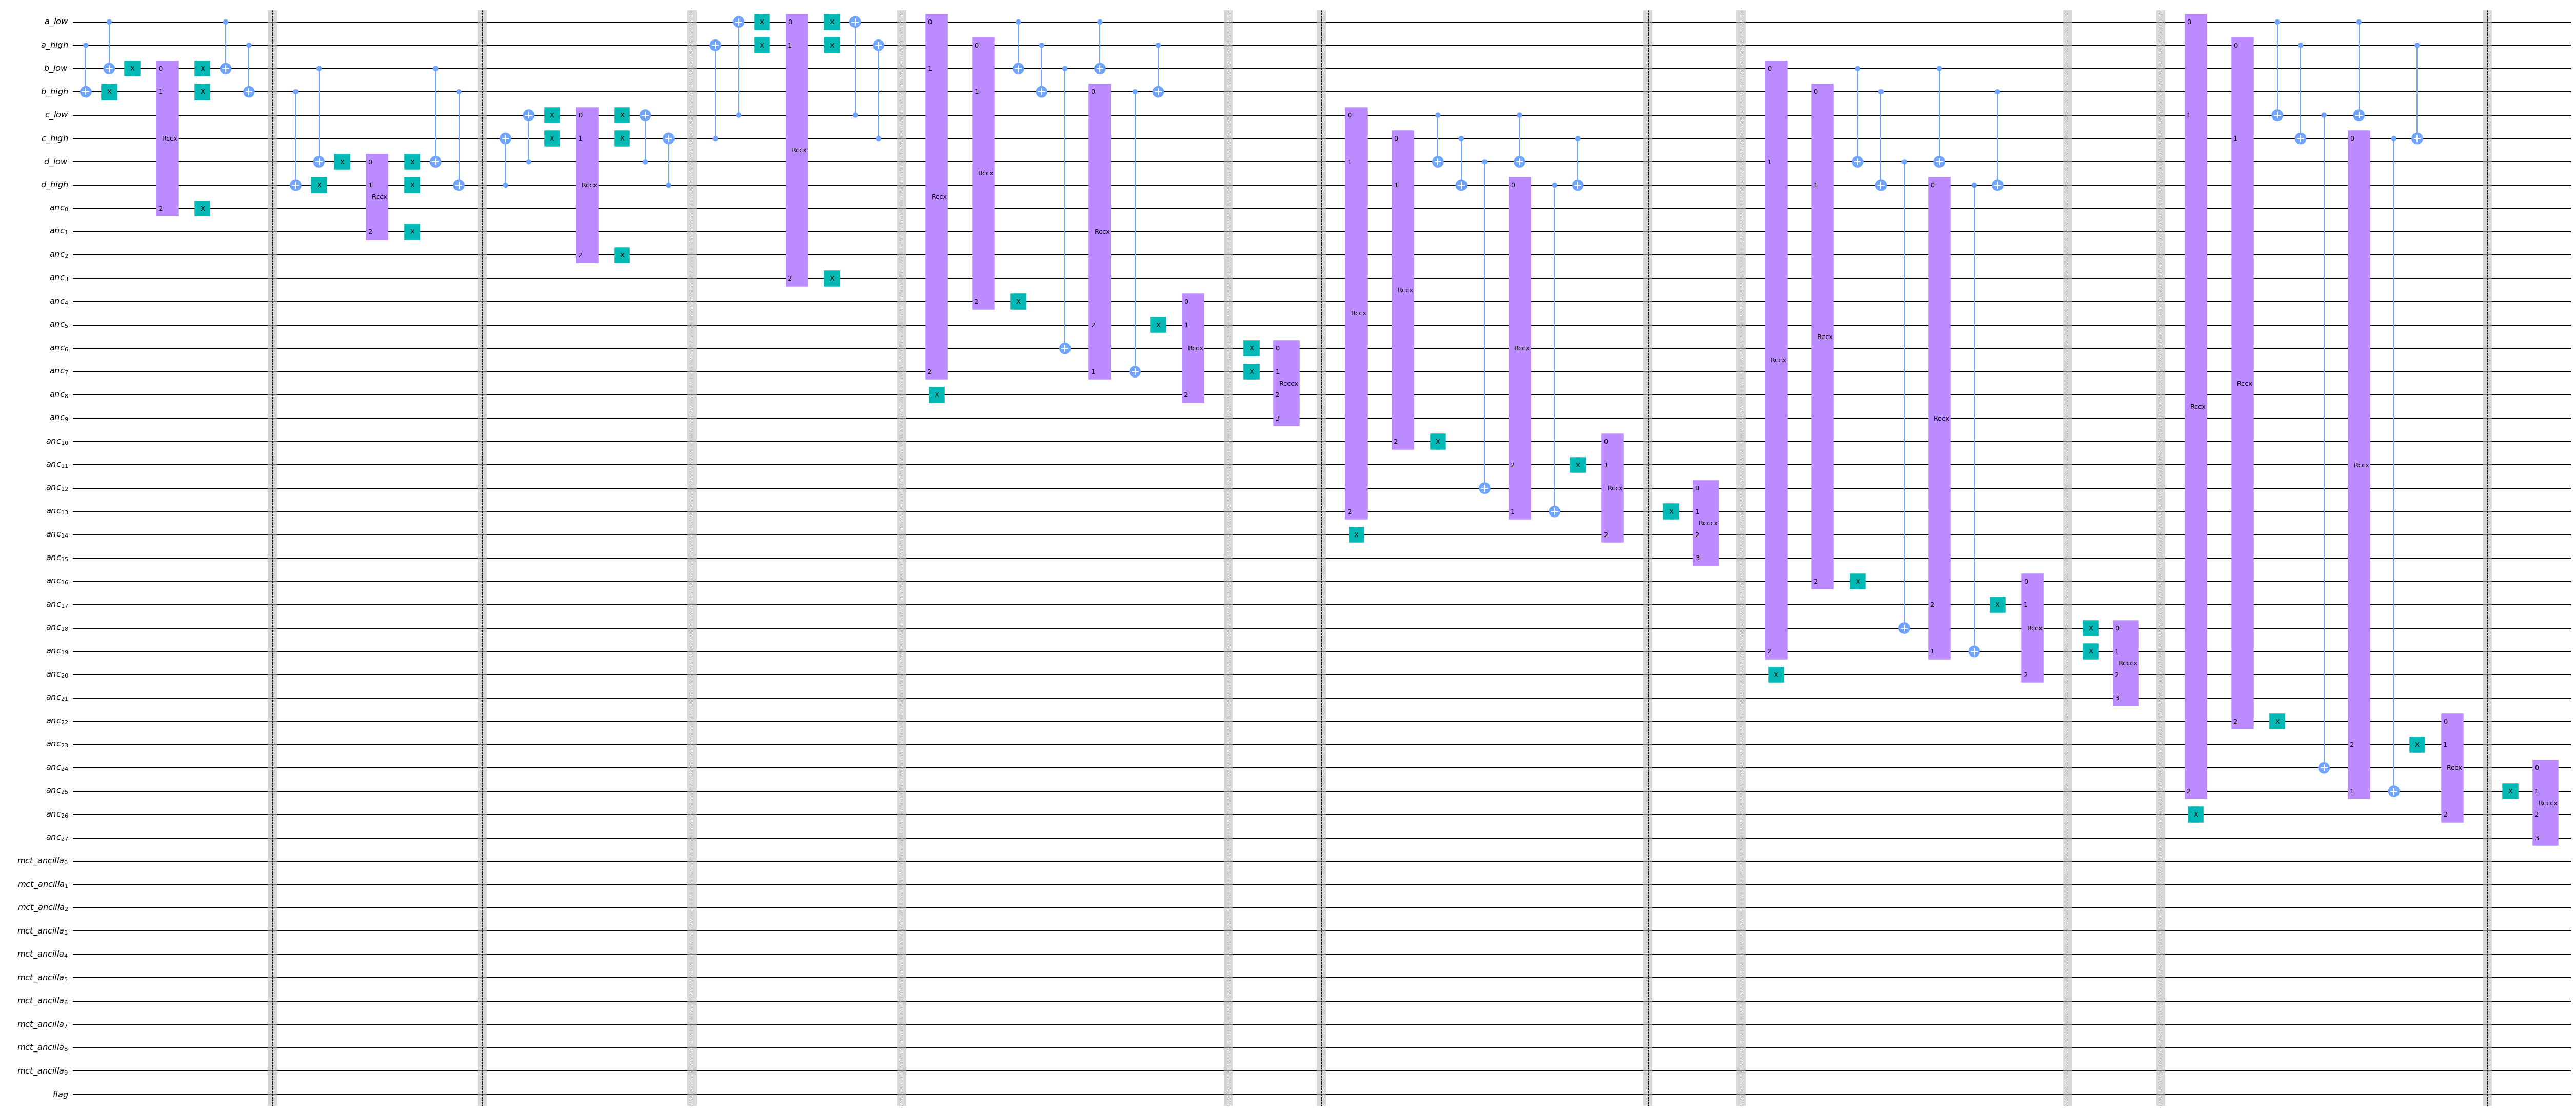

In [8]:
mct_list = []

# Inequalities
check_inequality(qc, a, b, anc[0])
mct_list.append(anc[0])
qc.barrier()
check_inequality(qc, b, d, anc[1])
mct_list.append(anc[1])
qc.barrier()
check_inequality(qc, d, c, anc[2])
mct_list.append(anc[2])
qc.barrier()
check_inequality(qc, c, a, anc[3])
mct_list.append(anc[3])
qc.barrier()


# Equalities smarter
tmp_1 = add_two_numbers(qc, a, b, anc[4:6], anc[6], anc[7], anc[8])
qc.barrier()
check_equality_smarter(qc, tmp_1, bin(s2_input)[2:].zfill(3), anc[9])
mct_list.append(anc[9])
qc.barrier()

tmp_2 = add_two_numbers(qc, c, d, anc[10:12], anc[12], anc[13], anc[14])
qc.barrier()
check_equality_smarter(qc, tmp_2, bin(s3_input)[2:].zfill(3), anc[15])
mct_list.append(anc[15])
qc.barrier()

tmp_3 = add_two_numbers(qc, b, d, anc[16:18], anc[18], anc[19], anc[20])
qc.barrier()
check_equality_smarter(qc, tmp_3, bin(s1_input)[2:].zfill(3), anc[21])
mct_list.append(anc[21])
qc.barrier()

tmp_4 = add_two_numbers(qc, a, c, anc[22:24], anc[24], anc[25], anc[26])
qc.barrier()
check_equality_smarter(qc, tmp_4, bin(s0_input)[2:].zfill(3), anc[27])
mct_list.append(anc[27])

qc.draw(output="mpl", fold=-1)

# Create Oracle

Complete Oracle (CX):  290
Complete Oracle (U):  316


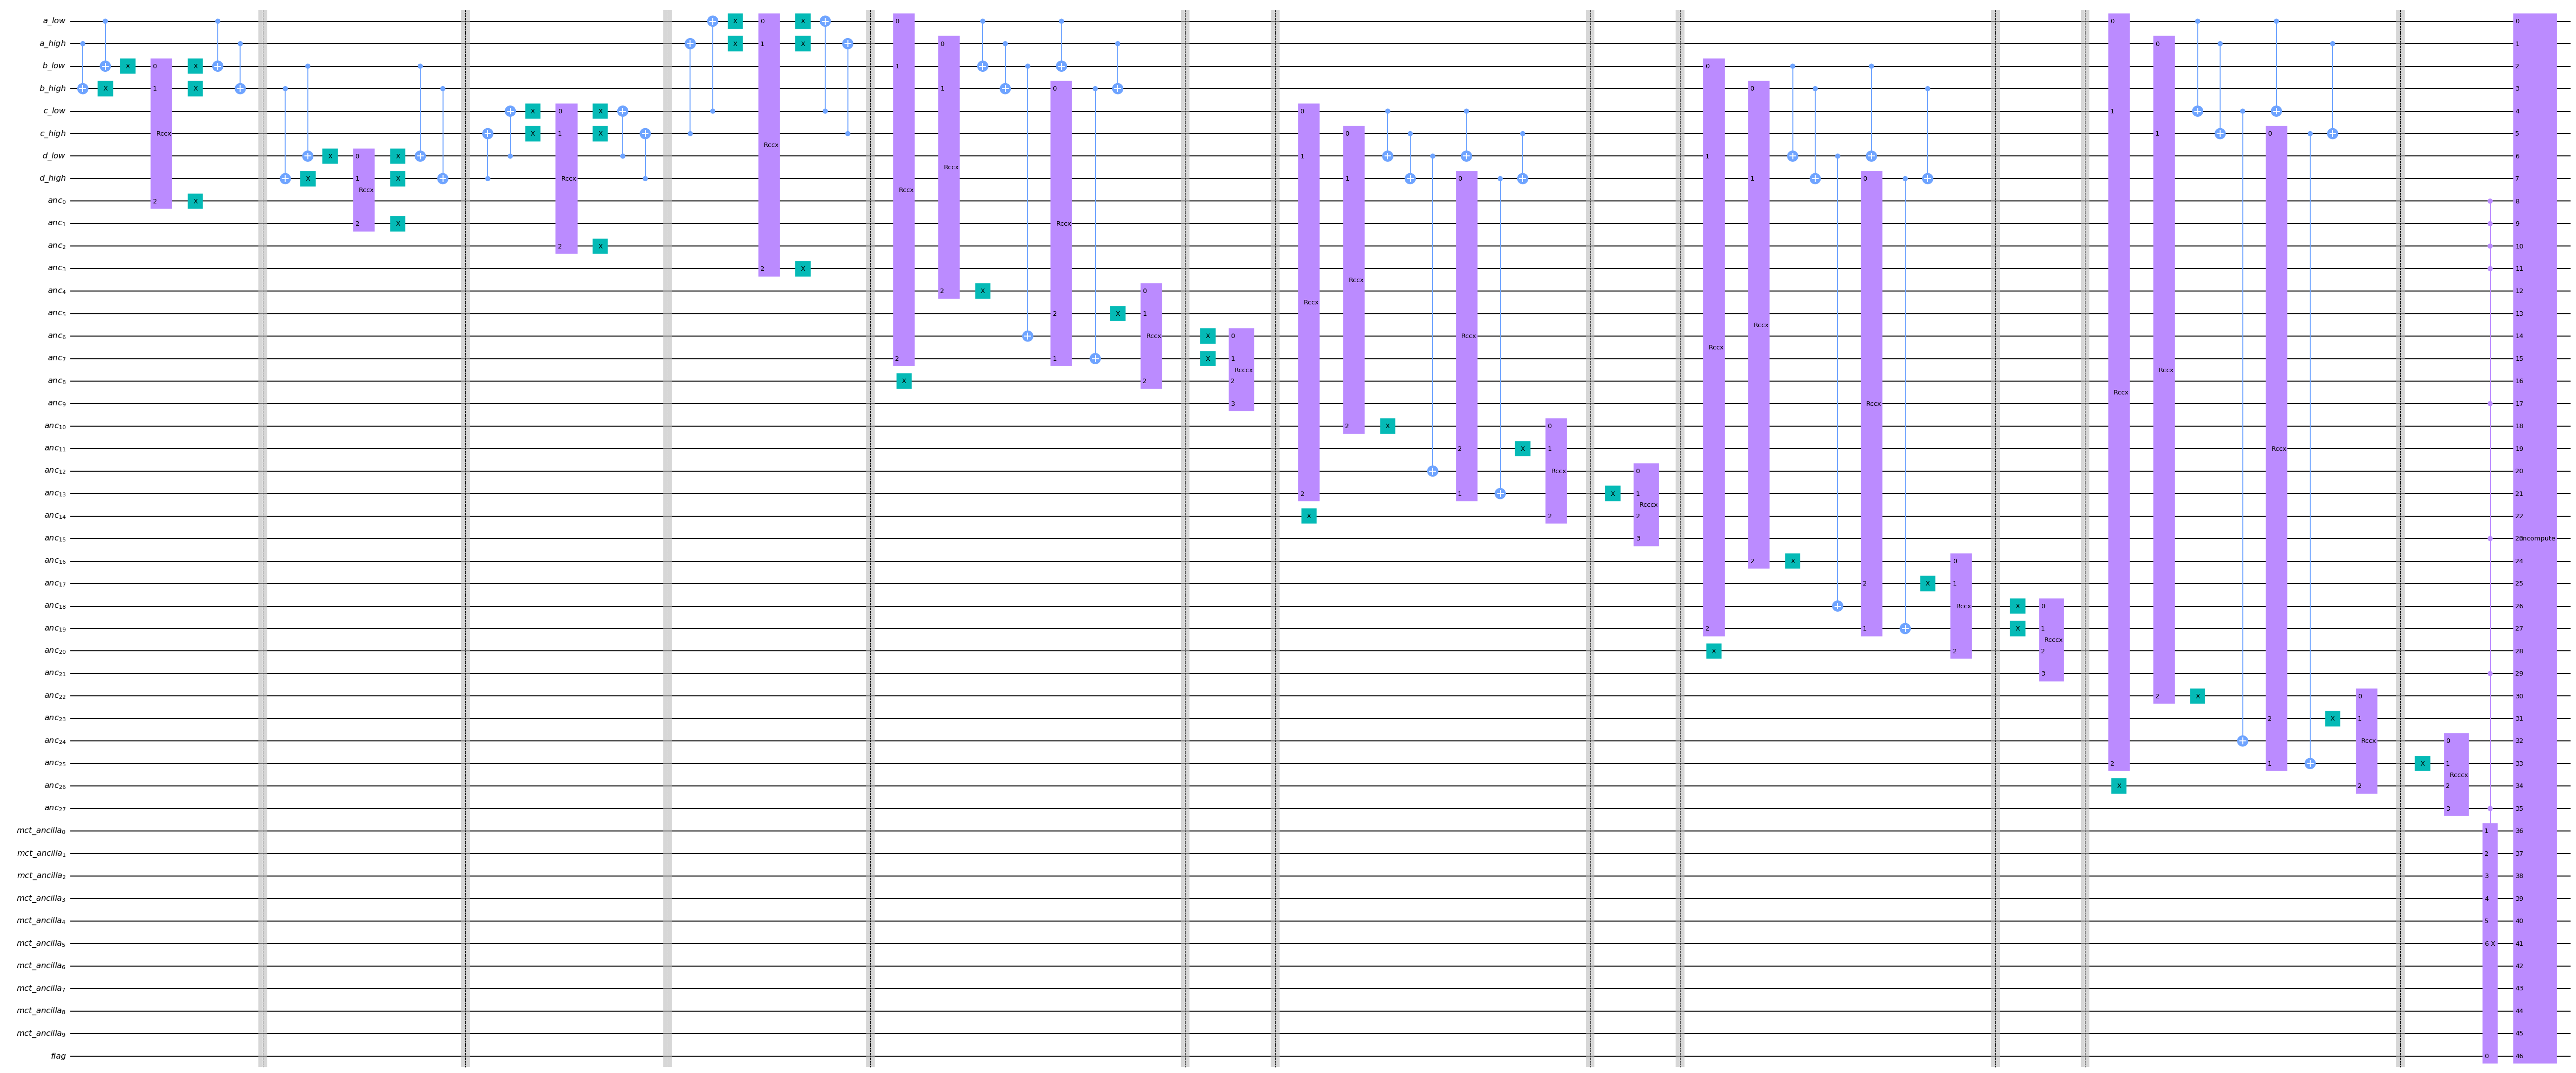

In [9]:
compute = qc.to_instruction()

# mark solution
qc.mct(mct_list, flag, ancilla_qubits=anc_mct, mode="v-chain")

# uncompute
uncompute = compute.inverse()
uncompute.name = "uncompute"
qc.append(uncompute, range(qc.num_qubits))


print(
    "Complete Oracle (CX): ", transpile(qc, basis_gates=["u", "cx"]).count_ops()["cx"]
)
print("Complete Oracle (U): ", transpile(qc, basis_gates=["u", "cx"]).count_ops()["u"])
oracle = qc.to_instruction(label="oracle")
qc.draw(output="mpl", fold=-1)

# Testing the Oracle

In [10]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim

backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
for i in range(2**8):
    new = QuantumCircuit(nqubits + nancilla, 1)
    for j in range(8):
        if (i >> j) % 2 == 1:
            new.x(j)
    new.append(oracle, range(nqubits + nancilla))
    new.measure(nqubits + nancilla - 1, 0)

    job = execute(new, backend, shots=10)
    counts = job.result().get_counts(new)
    # print("{0:b}".format(i), counts)
    if counts.get("1"):
        print("{0:b}".format(i), counts)

/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


11100111 {'1': 10}


# Embedding in Grover Algorithm and Execution on Simulator

m:  5
Solution found


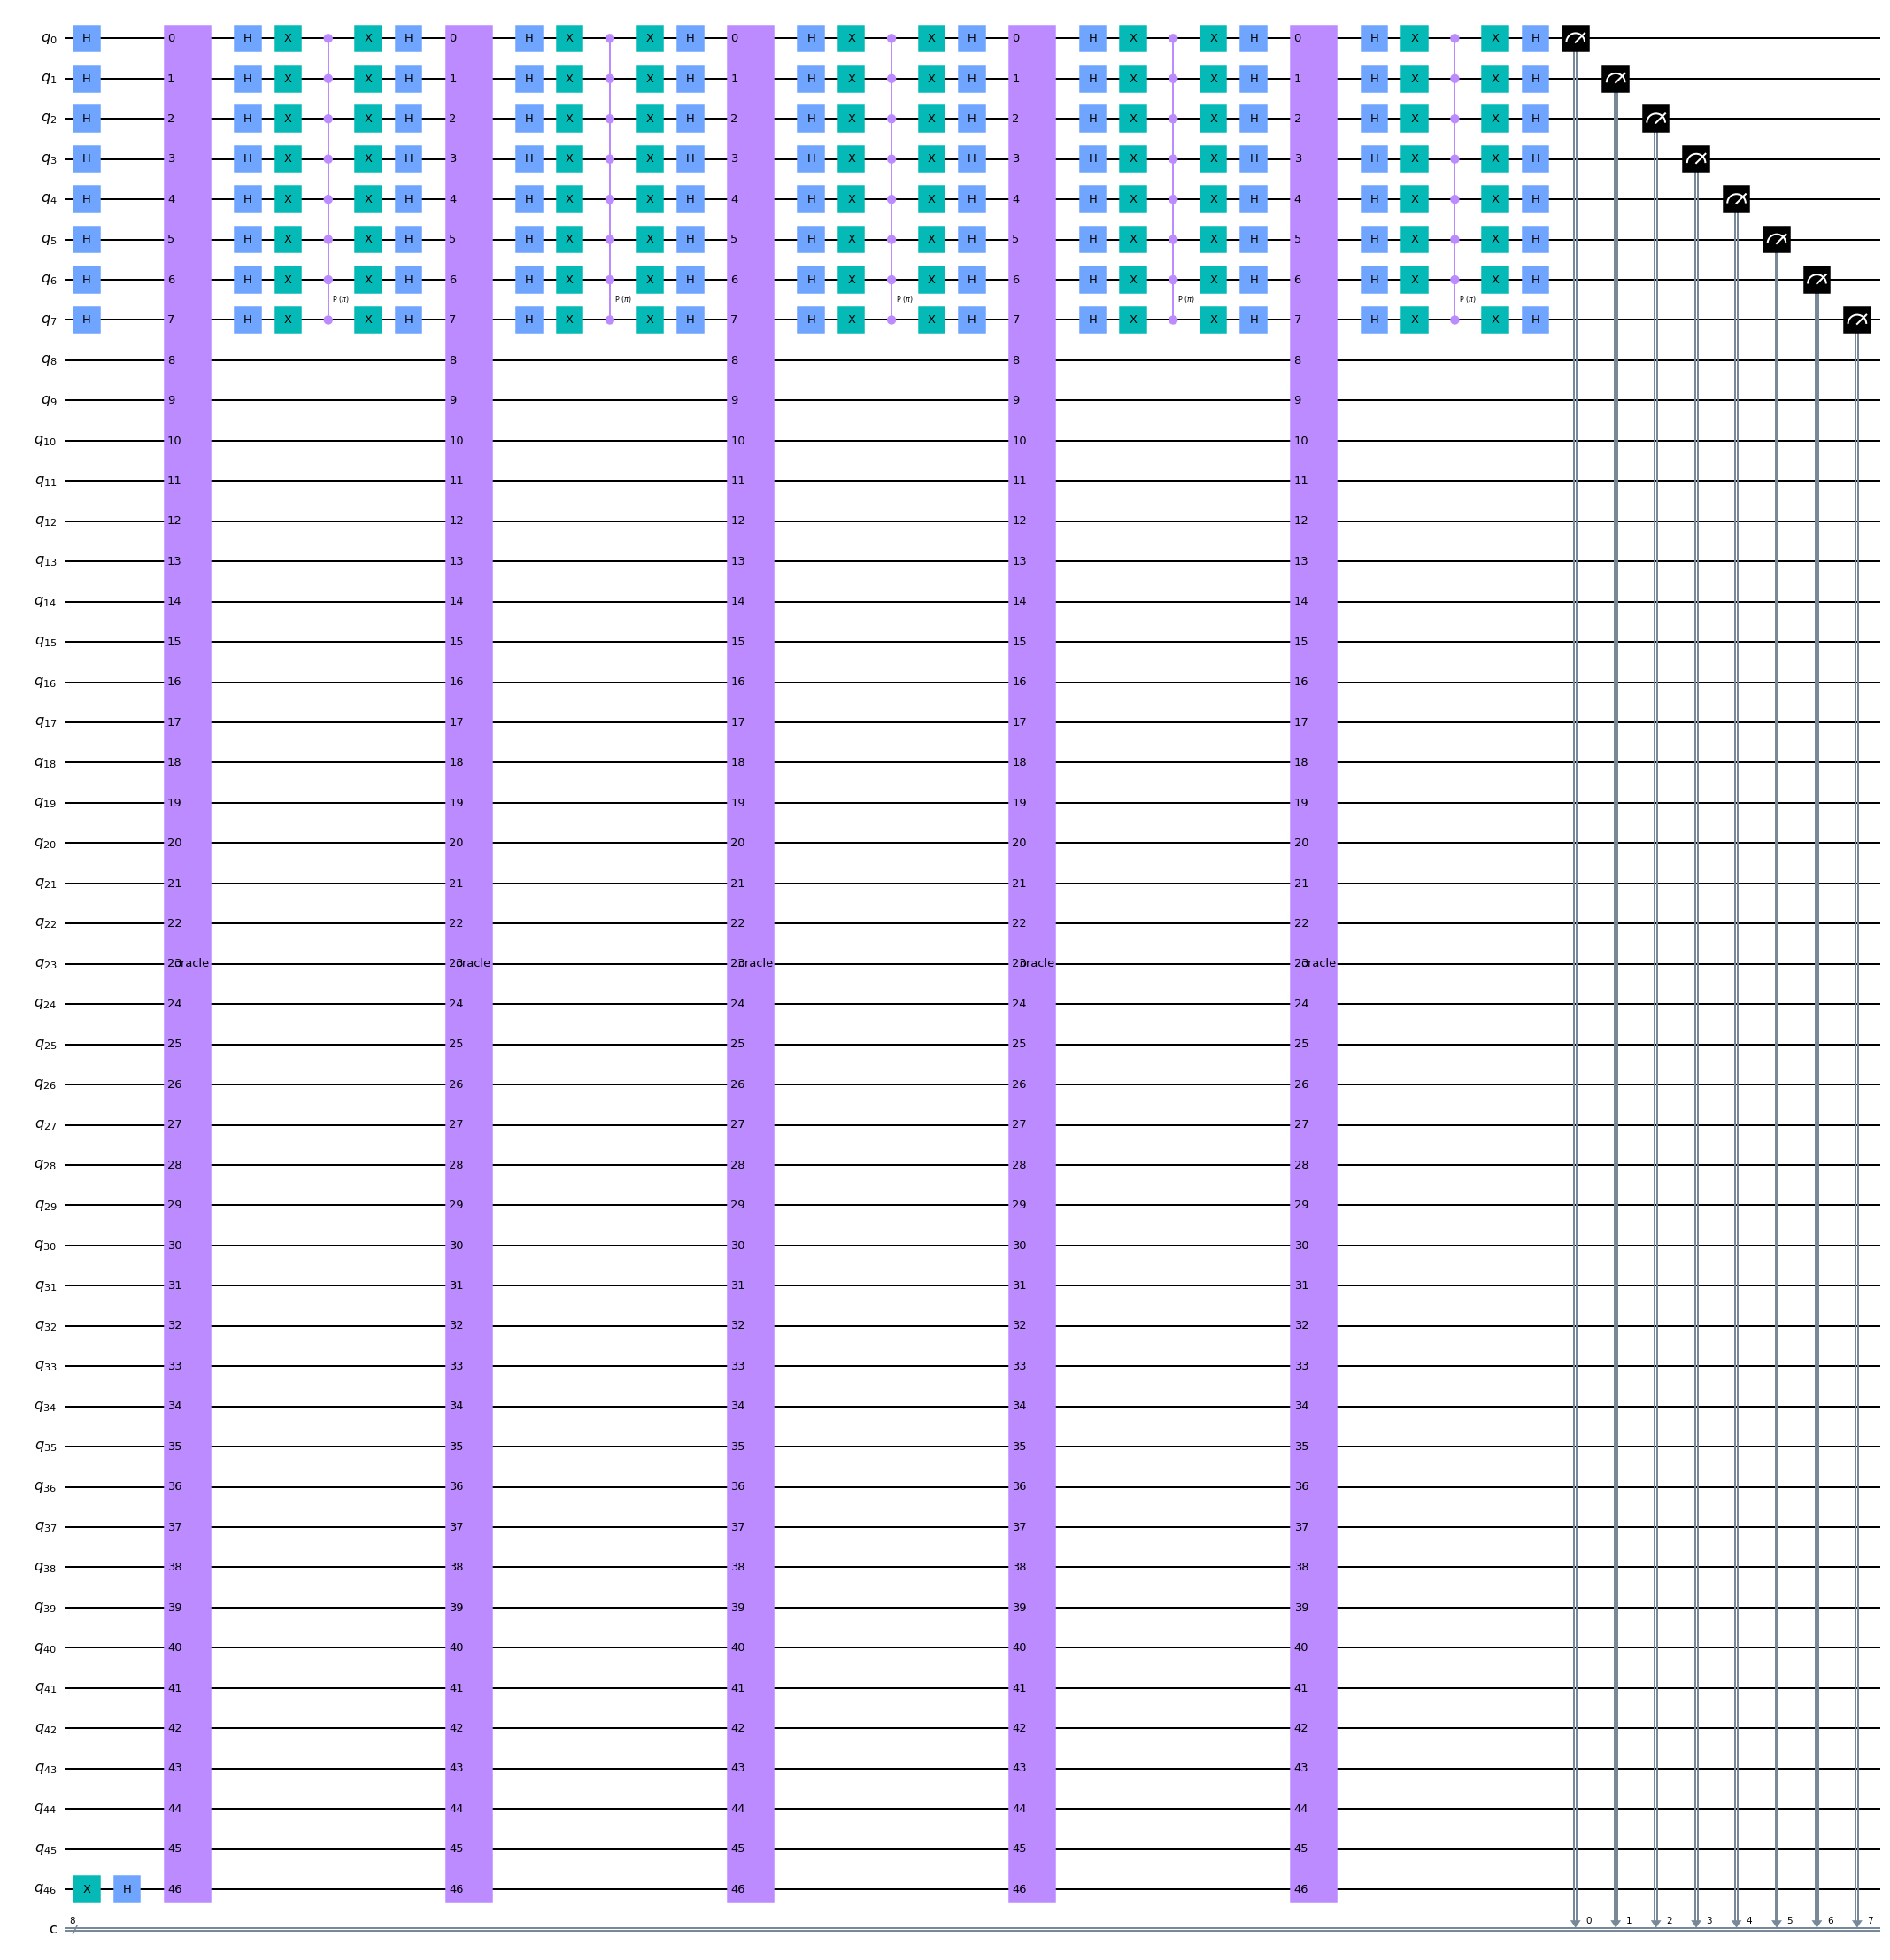

In [11]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
from qiskit.visualization import plot_histogram

# num_iterations = Grover.optimal_num_iterations(1, ninputs)
found_sol = False
for m in (5, 6, 7, 8, 12):
    print("m: ", round(m))
    qc = QuantumCircuit(nqubits + nancilla, ninputs)
    qc.h(range(ninputs))
    qc.x(nqubits + nancilla - 1)
    qc.h(nqubits + nancilla - 1)
    # print(num_iterations)
    for _ in range(round(m)):
        qc.append(oracle, range(nqubits + nancilla))
        qc.h(range(ninputs))
        qc.x(range(ninputs))
        qc.mcp(np.pi, list(range(ninputs - 1)), ninputs - 1)
        qc.x(range(ninputs))
        qc.h(range(ninputs))
    qc.measure(range(ninputs), range(ninputs))

    backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
    job = execute(qc, backend, shots=10000)
    counts = job.result().get_counts(qc)

    mean_counts = np.mean(list(counts.values()))
    for entry in counts.keys():

        if counts.get(entry) > 5 * mean_counts:
            print("Solution found")
            found_sol = True
            break
    if found_sol:
        break
qc.draw(output="mpl", fold=-1)

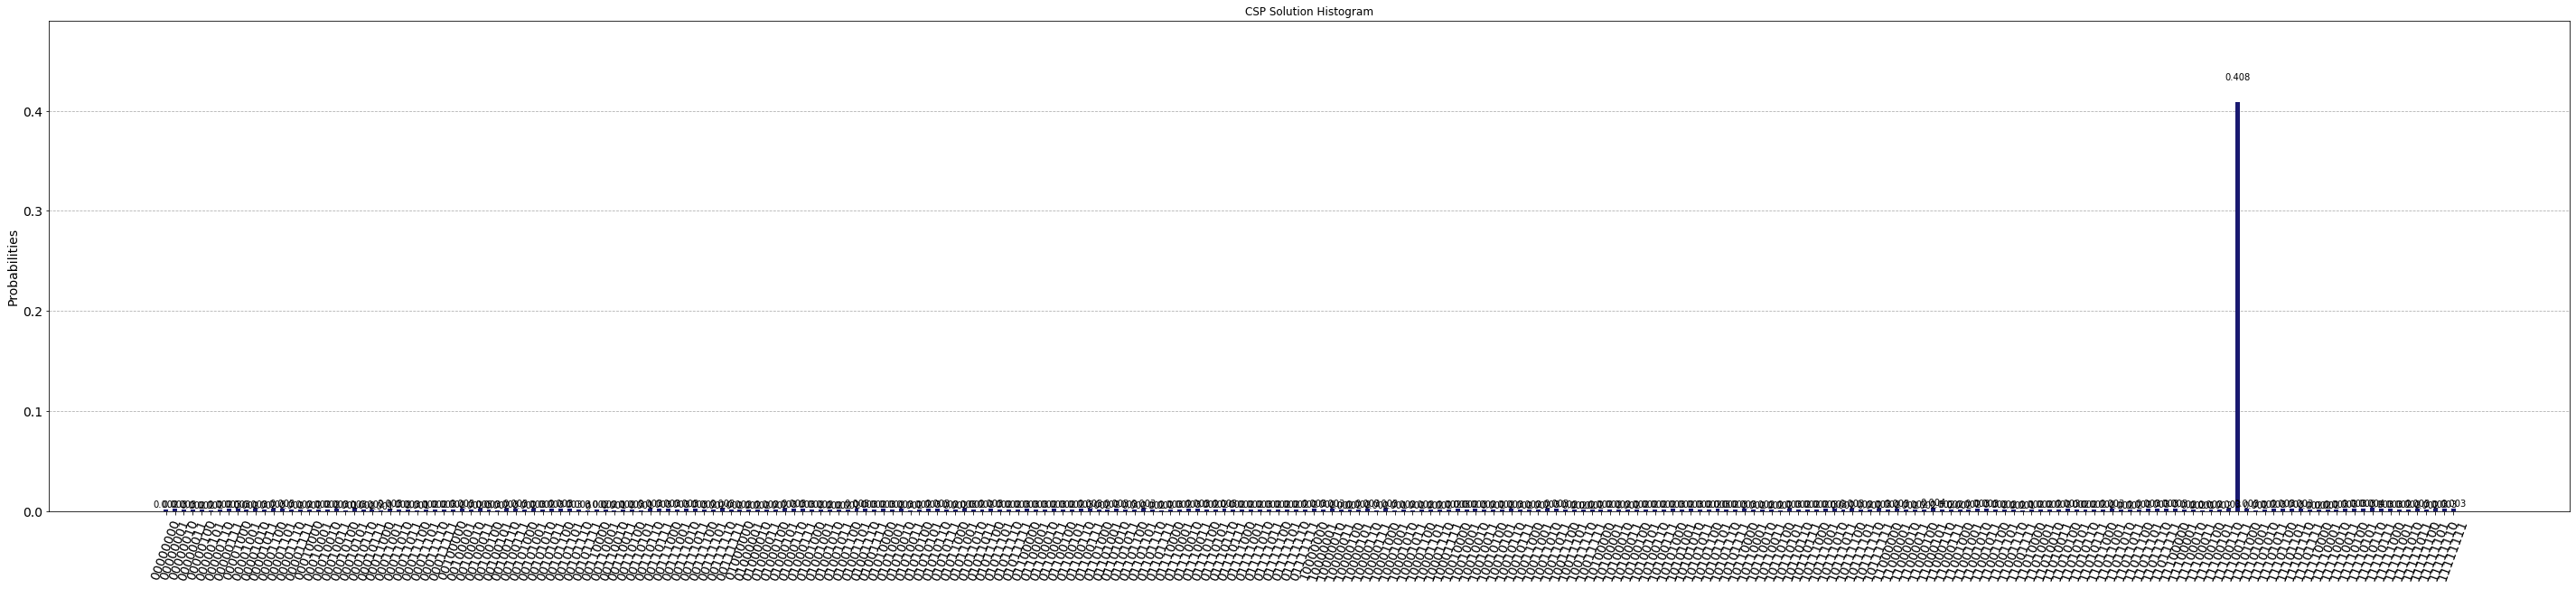

In [12]:
plot_histogram(
    counts, color="midnightblue", title="CSP Solution Histogram", figsize=(50, 10)
)

# Decoding/Interpretation

In [13]:
def print_kakuro(a, b, c, d, s0, s1, s2, s3):
    print("     | ", s0, " | ", s1, " |")
    print("------------------")
    print(" ", s2, " | ", a, " | ", b, " |")
    print("------------------")
    print(" ", s3, " | ", c, " | ", d, " |")
    print("------------------\n")

In [14]:
if found_sol:
    for entry in counts.keys():
        d = int(entry[0:2], 2)
        c = int(entry[2:4], 2)
        b = int(entry[4:6], 2)
        a = int(entry[6:8], 2)
        if counts.get(entry) > 5 * mean_counts:
            print_kakuro(a, b, c, d, s0_input, s1_input, s2_input, s3_input)
else:
    print("Sums are impossible to satisfy. Please try another setup.")

     |  5  |  4  |
------------------
  4  |  3  |  1  |
------------------
  5  |  2  |  3  |
------------------

